# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

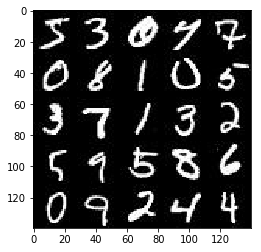

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

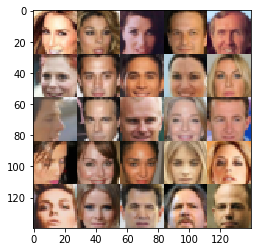

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_inputs")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="lr")
    return real_inputs, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, keep_prob=0.4):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #Input 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x = tf.maximum(alpha*x, x)
        #Output 14x14x64
        
        x2 = tf.layers.conv2d(x, 128, 5, strides=2, padding='SAME',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        #Output 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='SAME',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        #Output 4x4x256
        
        logits = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(logits, 1)
        logits = tf.nn.dropout(logits, keep_prob=keep_prob)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1, keep_prob=0.7):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512, kernel_initializer=tf.truncated_normal_initializer(stddev=0.02))
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha*x, x)
        # output 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x, 256, 5, strides=1, padding='SAME',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # output 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # output 14x14x128
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='SAME',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=tf.set_random_seed(1)))
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        # output 28x28x64
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=1, padding='SAME')
        # output 28x28xoutput_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function

    # Generator network
    g_model = generator(input_z, out_channel_dim)

    # Disriminator network
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
        
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
         print_every=10, show_every=150):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_inputs, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_input: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 1.3848... Generator Loss: 3.1496
Epoch 1/4... Discriminator Loss: 2.2704... Generator Loss: 0.5756
Epoch 1/4... Discriminator Loss: 2.4747... Generator Loss: 0.5616
Epoch 1/4... Discriminator Loss: 2.7734... Generator Loss: 1.2630
Epoch 1/4... Discriminator Loss: 1.1486... Generator Loss: 3.7292
Epoch 1/4... Discriminator Loss: 2.1183... Generator Loss: 1.4365
Epoch 1/4... Discriminator Loss: 2.4087... Generator Loss: 2.1447
Epoch 1/4... Discriminator Loss: 1.6786... Generator Loss: 2.0834
Epoch 1/4... Discriminator Loss: 1.7006... Generator Loss: 1.8583
Epoch 1/4... Discriminator Loss: 1.6428... Generator Loss: 2.2418
Epoch 1/4... Discriminator Loss: 1.2752... Generator Loss: 1.9393
Epoch 1/4... Discriminator Loss: 1.7562... Generator Loss: 2.2499
Epoch 1/4... Discriminator Loss: 1.6105... Generator Loss: 1.9957
Epoch 1/4... Discriminator Loss: 1.6358... Generator Loss: 1.3275
Epoch 1/4... Discriminator Loss: 1.7176... Generator Loss: 1.3078


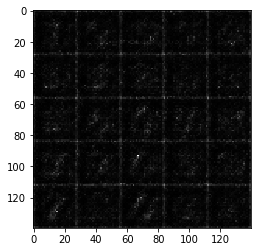

Epoch 1/4... Discriminator Loss: 1.6911... Generator Loss: 1.9858
Epoch 1/4... Discriminator Loss: 2.9757... Generator Loss: 0.9976
Epoch 1/4... Discriminator Loss: 2.1190... Generator Loss: 2.5570
Epoch 1/4... Discriminator Loss: 2.2038... Generator Loss: 2.1182
Epoch 1/4... Discriminator Loss: 2.3268... Generator Loss: 1.0715
Epoch 1/4... Discriminator Loss: 2.3698... Generator Loss: 1.0634
Epoch 1/4... Discriminator Loss: 1.4777... Generator Loss: 1.4142
Epoch 1/4... Discriminator Loss: 1.9038... Generator Loss: 2.4027
Epoch 1/4... Discriminator Loss: 1.7968... Generator Loss: 0.8362
Epoch 1/4... Discriminator Loss: 1.8946... Generator Loss: 2.0662
Epoch 1/4... Discriminator Loss: 1.9316... Generator Loss: 2.5191
Epoch 1/4... Discriminator Loss: 1.3152... Generator Loss: 2.1140
Epoch 1/4... Discriminator Loss: 2.0348... Generator Loss: 0.9621
Epoch 1/4... Discriminator Loss: 2.0336... Generator Loss: 1.0063
Epoch 1/4... Discriminator Loss: 1.7632... Generator Loss: 1.9839


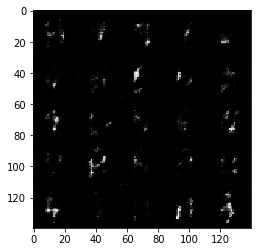

Epoch 1/4... Discriminator Loss: 1.3327... Generator Loss: 0.9224
Epoch 1/4... Discriminator Loss: 1.3859... Generator Loss: 1.4369
Epoch 1/4... Discriminator Loss: 1.7677... Generator Loss: 1.1172
Epoch 1/4... Discriminator Loss: 1.5760... Generator Loss: 0.9889
Epoch 1/4... Discriminator Loss: 1.5419... Generator Loss: 0.8471
Epoch 1/4... Discriminator Loss: 1.5300... Generator Loss: 1.0341
Epoch 1/4... Discriminator Loss: 1.8876... Generator Loss: 0.9214
Epoch 1/4... Discriminator Loss: 1.3563... Generator Loss: 1.1083
Epoch 1/4... Discriminator Loss: 1.4379... Generator Loss: 1.2850
Epoch 1/4... Discriminator Loss: 1.2597... Generator Loss: 0.7675
Epoch 1/4... Discriminator Loss: 1.3219... Generator Loss: 1.4502
Epoch 1/4... Discriminator Loss: 1.4045... Generator Loss: 1.4723
Epoch 1/4... Discriminator Loss: 1.5143... Generator Loss: 0.7966
Epoch 1/4... Discriminator Loss: 1.3730... Generator Loss: 1.4329
Epoch 1/4... Discriminator Loss: 1.6806... Generator Loss: 0.7320


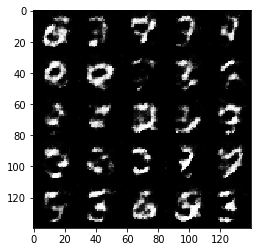

Epoch 1/4... Discriminator Loss: 1.9238... Generator Loss: 1.0409
Epoch 1/4... Discriminator Loss: 1.7768... Generator Loss: 0.7577
Epoch 1/4... Discriminator Loss: 1.5224... Generator Loss: 0.7026
Epoch 1/4... Discriminator Loss: 1.8060... Generator Loss: 0.7396
Epoch 1/4... Discriminator Loss: 1.6684... Generator Loss: 1.7794
Epoch 1/4... Discriminator Loss: 1.6432... Generator Loss: 0.7882
Epoch 1/4... Discriminator Loss: 1.3314... Generator Loss: 1.1846
Epoch 1/4... Discriminator Loss: 1.5652... Generator Loss: 0.7182
Epoch 1/4... Discriminator Loss: 1.3099... Generator Loss: 1.3740
Epoch 1/4... Discriminator Loss: 1.4696... Generator Loss: 0.7662
Epoch 1/4... Discriminator Loss: 1.4092... Generator Loss: 0.8271
Epoch 1/4... Discriminator Loss: 1.5223... Generator Loss: 0.9357
Epoch 1/4... Discriminator Loss: 1.5377... Generator Loss: 1.0679
Epoch 1/4... Discriminator Loss: 1.2640... Generator Loss: 1.6355
Epoch 1/4... Discriminator Loss: 1.4591... Generator Loss: 0.8980


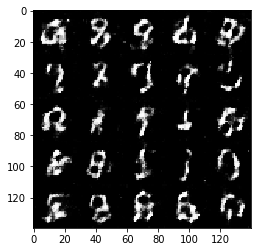

Epoch 1/4... Discriminator Loss: 1.5207... Generator Loss: 1.1879
Epoch 1/4... Discriminator Loss: 1.4427... Generator Loss: 1.5790
Epoch 1/4... Discriminator Loss: 1.7597... Generator Loss: 0.9973
Epoch 1/4... Discriminator Loss: 1.4548... Generator Loss: 1.0514
Epoch 1/4... Discriminator Loss: 1.8687... Generator Loss: 1.3904
Epoch 1/4... Discriminator Loss: 1.4296... Generator Loss: 1.2475
Epoch 1/4... Discriminator Loss: 1.6480... Generator Loss: 0.8231
Epoch 1/4... Discriminator Loss: 1.5325... Generator Loss: 1.1383
Epoch 1/4... Discriminator Loss: 1.6071... Generator Loss: 1.0179
Epoch 1/4... Discriminator Loss: 1.6616... Generator Loss: 0.7379
Epoch 1/4... Discriminator Loss: 1.3558... Generator Loss: 1.2217
Epoch 1/4... Discriminator Loss: 1.5095... Generator Loss: 0.7558
Epoch 1/4... Discriminator Loss: 1.1994... Generator Loss: 1.0662
Epoch 1/4... Discriminator Loss: 1.5840... Generator Loss: 0.8819
Epoch 1/4... Discriminator Loss: 1.4201... Generator Loss: 0.6361


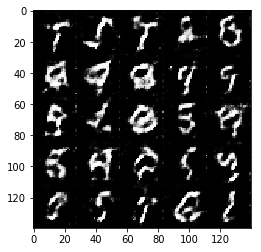

Epoch 1/4... Discriminator Loss: 1.4208... Generator Loss: 0.9470
Epoch 1/4... Discriminator Loss: 1.6489... Generator Loss: 1.3561
Epoch 1/4... Discriminator Loss: 1.2543... Generator Loss: 0.7637
Epoch 1/4... Discriminator Loss: 1.3071... Generator Loss: 1.2183
Epoch 1/4... Discriminator Loss: 1.5509... Generator Loss: 1.0697
Epoch 1/4... Discriminator Loss: 1.4315... Generator Loss: 0.9313
Epoch 1/4... Discriminator Loss: 1.4554... Generator Loss: 0.8771
Epoch 1/4... Discriminator Loss: 1.4238... Generator Loss: 1.0015
Epoch 1/4... Discriminator Loss: 1.4161... Generator Loss: 0.9840
Epoch 1/4... Discriminator Loss: 1.3353... Generator Loss: 0.8028
Epoch 1/4... Discriminator Loss: 1.2513... Generator Loss: 0.6591
Epoch 1/4... Discriminator Loss: 1.5187... Generator Loss: 1.0131
Epoch 1/4... Discriminator Loss: 1.2819... Generator Loss: 0.9071
Epoch 1/4... Discriminator Loss: 1.2787... Generator Loss: 1.0033
Epoch 1/4... Discriminator Loss: 1.5611... Generator Loss: 1.5145


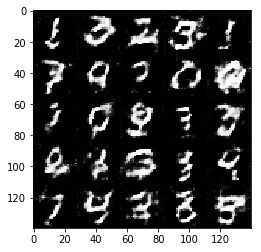

Epoch 1/4... Discriminator Loss: 1.4450... Generator Loss: 0.9512
Epoch 1/4... Discriminator Loss: 1.6651... Generator Loss: 1.1774
Epoch 1/4... Discriminator Loss: 1.3454... Generator Loss: 0.8743
Epoch 1/4... Discriminator Loss: 1.5262... Generator Loss: 0.6978
Epoch 1/4... Discriminator Loss: 1.3513... Generator Loss: 0.7967
Epoch 1/4... Discriminator Loss: 1.3115... Generator Loss: 0.7553
Epoch 1/4... Discriminator Loss: 1.6252... Generator Loss: 1.1298
Epoch 1/4... Discriminator Loss: 1.5730... Generator Loss: 1.0554
Epoch 1/4... Discriminator Loss: 1.3154... Generator Loss: 0.7796
Epoch 1/4... Discriminator Loss: 1.3510... Generator Loss: 1.1688
Epoch 1/4... Discriminator Loss: 1.4466... Generator Loss: 0.7828
Epoch 1/4... Discriminator Loss: 1.3950... Generator Loss: 0.9225
Epoch 1/4... Discriminator Loss: 1.5445... Generator Loss: 0.9239
Epoch 1/4... Discriminator Loss: 1.4030... Generator Loss: 0.9087
Epoch 1/4... Discriminator Loss: 1.4264... Generator Loss: 1.1972


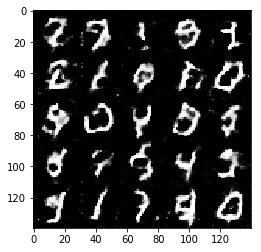

Epoch 1/4... Discriminator Loss: 1.3840... Generator Loss: 0.9688
Epoch 1/4... Discriminator Loss: 1.4542... Generator Loss: 1.2197
Epoch 1/4... Discriminator Loss: 1.5563... Generator Loss: 1.1188
Epoch 1/4... Discriminator Loss: 1.4467... Generator Loss: 1.2228
Epoch 1/4... Discriminator Loss: 1.3400... Generator Loss: 0.8951
Epoch 1/4... Discriminator Loss: 1.6765... Generator Loss: 0.5870
Epoch 1/4... Discriminator Loss: 1.6566... Generator Loss: 0.6500
Epoch 1/4... Discriminator Loss: 1.4254... Generator Loss: 0.9013
Epoch 1/4... Discriminator Loss: 1.4374... Generator Loss: 1.4050
Epoch 1/4... Discriminator Loss: 1.3150... Generator Loss: 0.7253
Epoch 1/4... Discriminator Loss: 1.3883... Generator Loss: 1.3260
Epoch 1/4... Discriminator Loss: 1.3225... Generator Loss: 0.6328
Epoch 1/4... Discriminator Loss: 1.4208... Generator Loss: 0.9705
Epoch 1/4... Discriminator Loss: 1.3566... Generator Loss: 1.0256
Epoch 1/4... Discriminator Loss: 1.3199... Generator Loss: 0.8241


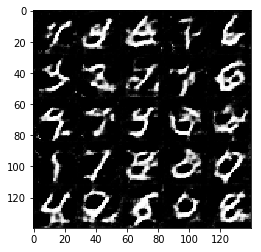

Epoch 1/4... Discriminator Loss: 1.4175... Generator Loss: 1.0141
Epoch 1/4... Discriminator Loss: 1.3538... Generator Loss: 0.8098
Epoch 1/4... Discriminator Loss: 1.3368... Generator Loss: 0.9267
Epoch 1/4... Discriminator Loss: 1.4784... Generator Loss: 0.9324
Epoch 1/4... Discriminator Loss: 1.2837... Generator Loss: 1.0425
Epoch 1/4... Discriminator Loss: 1.2894... Generator Loss: 0.9184
Epoch 1/4... Discriminator Loss: 1.5127... Generator Loss: 1.0681
Epoch 1/4... Discriminator Loss: 1.3700... Generator Loss: 0.9551
Epoch 1/4... Discriminator Loss: 1.3978... Generator Loss: 0.8351
Epoch 1/4... Discriminator Loss: 1.3504... Generator Loss: 0.9195
Epoch 1/4... Discriminator Loss: 1.3483... Generator Loss: 1.0201
Epoch 1/4... Discriminator Loss: 1.4965... Generator Loss: 0.9422
Epoch 1/4... Discriminator Loss: 1.4379... Generator Loss: 0.8860
Epoch 1/4... Discriminator Loss: 1.3722... Generator Loss: 0.9300
Epoch 1/4... Discriminator Loss: 1.4911... Generator Loss: 0.6236


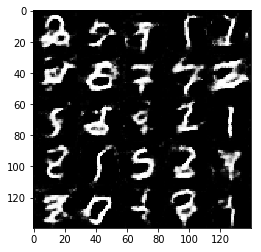

Epoch 1/4... Discriminator Loss: 1.5842... Generator Loss: 1.0519
Epoch 1/4... Discriminator Loss: 1.3490... Generator Loss: 0.7503
Epoch 1/4... Discriminator Loss: 1.3760... Generator Loss: 0.9998
Epoch 1/4... Discriminator Loss: 1.2751... Generator Loss: 0.7611
Epoch 1/4... Discriminator Loss: 1.4225... Generator Loss: 0.7314
Epoch 1/4... Discriminator Loss: 1.3167... Generator Loss: 0.7699
Epoch 1/4... Discriminator Loss: 1.3722... Generator Loss: 0.6327
Epoch 1/4... Discriminator Loss: 1.3247... Generator Loss: 0.7369
Epoch 1/4... Discriminator Loss: 1.2775... Generator Loss: 0.9172
Epoch 1/4... Discriminator Loss: 1.3198... Generator Loss: 0.9208
Epoch 1/4... Discriminator Loss: 1.3488... Generator Loss: 1.0367
Epoch 1/4... Discriminator Loss: 1.3124... Generator Loss: 0.6982
Epoch 1/4... Discriminator Loss: 1.4043... Generator Loss: 0.9566
Epoch 1/4... Discriminator Loss: 1.4923... Generator Loss: 0.7184
Epoch 1/4... Discriminator Loss: 1.3329... Generator Loss: 1.0410


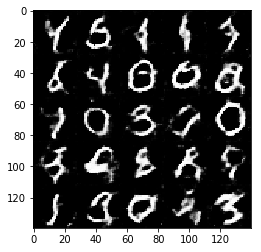

Epoch 1/4... Discriminator Loss: 1.3424... Generator Loss: 0.7381
Epoch 1/4... Discriminator Loss: 1.3173... Generator Loss: 0.7579
Epoch 1/4... Discriminator Loss: 1.4209... Generator Loss: 1.0398
Epoch 1/4... Discriminator Loss: 1.2959... Generator Loss: 0.9106
Epoch 1/4... Discriminator Loss: 1.3489... Generator Loss: 0.8832
Epoch 1/4... Discriminator Loss: 1.3808... Generator Loss: 0.7484
Epoch 1/4... Discriminator Loss: 1.3749... Generator Loss: 0.8057
Epoch 1/4... Discriminator Loss: 1.4134... Generator Loss: 0.9585
Epoch 1/4... Discriminator Loss: 1.4358... Generator Loss: 0.9299
Epoch 1/4... Discriminator Loss: 1.3805... Generator Loss: 0.9136
Epoch 1/4... Discriminator Loss: 1.3065... Generator Loss: 0.9377
Epoch 1/4... Discriminator Loss: 1.2969... Generator Loss: 0.8951
Epoch 1/4... Discriminator Loss: 1.2629... Generator Loss: 0.9061
Epoch 1/4... Discriminator Loss: 1.3019... Generator Loss: 1.0322
Epoch 1/4... Discriminator Loss: 1.3667... Generator Loss: 0.8466


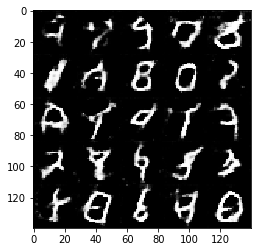

Epoch 1/4... Discriminator Loss: 1.4529... Generator Loss: 0.7222
Epoch 1/4... Discriminator Loss: 1.4210... Generator Loss: 0.6960
Epoch 1/4... Discriminator Loss: 1.3921... Generator Loss: 1.0120
Epoch 1/4... Discriminator Loss: 1.2252... Generator Loss: 1.0008
Epoch 1/4... Discriminator Loss: 1.2275... Generator Loss: 0.9367
Epoch 1/4... Discriminator Loss: 1.4206... Generator Loss: 0.9704
Epoch 1/4... Discriminator Loss: 1.5884... Generator Loss: 0.8479
Epoch 1/4... Discriminator Loss: 1.5612... Generator Loss: 0.9050
Epoch 1/4... Discriminator Loss: 1.3619... Generator Loss: 0.7261
Epoch 1/4... Discriminator Loss: 1.4107... Generator Loss: 0.8068
Epoch 1/4... Discriminator Loss: 1.3558... Generator Loss: 0.9548
Epoch 1/4... Discriminator Loss: 1.3442... Generator Loss: 0.9365
Epoch 1/4... Discriminator Loss: 1.4583... Generator Loss: 0.7677
Epoch 1/4... Discriminator Loss: 1.3153... Generator Loss: 0.8306
Epoch 1/4... Discriminator Loss: 1.3911... Generator Loss: 0.7501


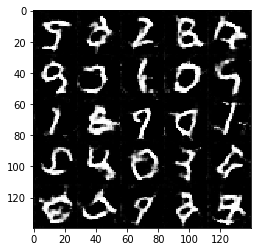

Epoch 1/4... Discriminator Loss: 1.4060... Generator Loss: 0.8608
Epoch 1/4... Discriminator Loss: 1.3727... Generator Loss: 1.3494
Epoch 1/4... Discriminator Loss: 1.3384... Generator Loss: 0.8034
Epoch 1/4... Discriminator Loss: 1.4688... Generator Loss: 1.3266
Epoch 1/4... Discriminator Loss: 1.2617... Generator Loss: 0.8516
Epoch 1/4... Discriminator Loss: 1.4140... Generator Loss: 0.8053
Epoch 1/4... Discriminator Loss: 1.4160... Generator Loss: 0.7806
Epoch 2/4... Discriminator Loss: 1.2802... Generator Loss: 1.0628
Epoch 2/4... Discriminator Loss: 1.3567... Generator Loss: 0.8259
Epoch 2/4... Discriminator Loss: 1.3748... Generator Loss: 0.7864
Epoch 2/4... Discriminator Loss: 1.5132... Generator Loss: 0.7042
Epoch 2/4... Discriminator Loss: 1.3883... Generator Loss: 0.8811
Epoch 2/4... Discriminator Loss: 1.3780... Generator Loss: 0.7435
Epoch 2/4... Discriminator Loss: 1.4399... Generator Loss: 1.1277
Epoch 2/4... Discriminator Loss: 1.3315... Generator Loss: 0.8828


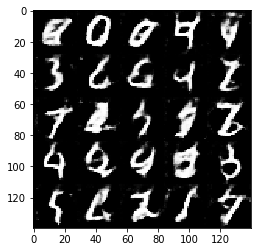

Epoch 2/4... Discriminator Loss: 1.3376... Generator Loss: 0.9416
Epoch 2/4... Discriminator Loss: 1.4338... Generator Loss: 0.7103
Epoch 2/4... Discriminator Loss: 1.4219... Generator Loss: 0.9400
Epoch 2/4... Discriminator Loss: 1.3567... Generator Loss: 0.8600
Epoch 2/4... Discriminator Loss: 1.4321... Generator Loss: 0.8973
Epoch 2/4... Discriminator Loss: 1.3074... Generator Loss: 0.7800
Epoch 2/4... Discriminator Loss: 1.3236... Generator Loss: 0.9276
Epoch 2/4... Discriminator Loss: 1.4473... Generator Loss: 0.8682
Epoch 2/4... Discriminator Loss: 1.1497... Generator Loss: 1.0053
Epoch 2/4... Discriminator Loss: 1.3964... Generator Loss: 0.9645
Epoch 2/4... Discriminator Loss: 1.3378... Generator Loss: 0.9067
Epoch 2/4... Discriminator Loss: 1.4069... Generator Loss: 0.9148
Epoch 2/4... Discriminator Loss: 1.4481... Generator Loss: 0.7565
Epoch 2/4... Discriminator Loss: 1.4214... Generator Loss: 0.7096
Epoch 2/4... Discriminator Loss: 1.4085... Generator Loss: 0.9803


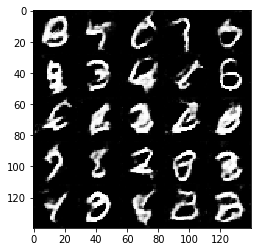

Epoch 2/4... Discriminator Loss: 1.3397... Generator Loss: 0.8999
Epoch 2/4... Discriminator Loss: 1.4740... Generator Loss: 0.7882
Epoch 2/4... Discriminator Loss: 1.3526... Generator Loss: 0.7519
Epoch 2/4... Discriminator Loss: 1.2185... Generator Loss: 0.6297
Epoch 2/4... Discriminator Loss: 1.5616... Generator Loss: 0.9619
Epoch 2/4... Discriminator Loss: 1.3479... Generator Loss: 0.9206
Epoch 2/4... Discriminator Loss: 1.2692... Generator Loss: 0.9320
Epoch 2/4... Discriminator Loss: 1.4884... Generator Loss: 0.7713
Epoch 2/4... Discriminator Loss: 1.4066... Generator Loss: 0.7073
Epoch 2/4... Discriminator Loss: 1.5293... Generator Loss: 0.8075
Epoch 2/4... Discriminator Loss: 1.5171... Generator Loss: 0.7050
Epoch 2/4... Discriminator Loss: 1.2395... Generator Loss: 0.7068
Epoch 2/4... Discriminator Loss: 1.5401... Generator Loss: 1.0606
Epoch 2/4... Discriminator Loss: 1.3312... Generator Loss: 0.7251
Epoch 2/4... Discriminator Loss: 1.3203... Generator Loss: 0.8465


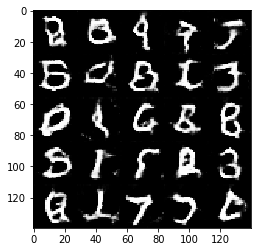

Epoch 2/4... Discriminator Loss: 1.3889... Generator Loss: 0.9625
Epoch 2/4... Discriminator Loss: 1.4801... Generator Loss: 1.0988
Epoch 2/4... Discriminator Loss: 1.4502... Generator Loss: 0.7026
Epoch 2/4... Discriminator Loss: 1.4393... Generator Loss: 1.0352
Epoch 2/4... Discriminator Loss: 1.3973... Generator Loss: 0.9169
Epoch 2/4... Discriminator Loss: 1.3239... Generator Loss: 0.9350
Epoch 2/4... Discriminator Loss: 1.4024... Generator Loss: 0.8829
Epoch 2/4... Discriminator Loss: 1.5853... Generator Loss: 0.7954
Epoch 2/4... Discriminator Loss: 1.3133... Generator Loss: 1.0229
Epoch 2/4... Discriminator Loss: 1.3642... Generator Loss: 1.1524
Epoch 2/4... Discriminator Loss: 1.3672... Generator Loss: 0.8187
Epoch 2/4... Discriminator Loss: 1.4710... Generator Loss: 0.8147
Epoch 2/4... Discriminator Loss: 1.4130... Generator Loss: 0.8802
Epoch 2/4... Discriminator Loss: 1.3552... Generator Loss: 0.8183
Epoch 2/4... Discriminator Loss: 1.5920... Generator Loss: 1.0270


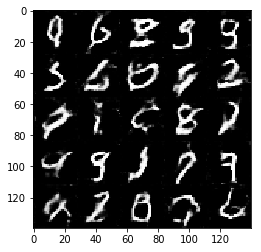

Epoch 2/4... Discriminator Loss: 1.3303... Generator Loss: 0.8048
Epoch 2/4... Discriminator Loss: 1.5415... Generator Loss: 0.7224
Epoch 2/4... Discriminator Loss: 1.4240... Generator Loss: 1.2181
Epoch 2/4... Discriminator Loss: 1.4125... Generator Loss: 0.9367
Epoch 2/4... Discriminator Loss: 1.4396... Generator Loss: 0.6847
Epoch 2/4... Discriminator Loss: 1.3977... Generator Loss: 0.8298
Epoch 2/4... Discriminator Loss: 1.3864... Generator Loss: 0.6601
Epoch 2/4... Discriminator Loss: 1.3374... Generator Loss: 0.7767
Epoch 2/4... Discriminator Loss: 1.4516... Generator Loss: 0.8542
Epoch 2/4... Discriminator Loss: 1.5303... Generator Loss: 0.7375
Epoch 2/4... Discriminator Loss: 1.3445... Generator Loss: 0.7227
Epoch 2/4... Discriminator Loss: 1.1594... Generator Loss: 0.8655
Epoch 2/4... Discriminator Loss: 1.3269... Generator Loss: 0.7331
Epoch 2/4... Discriminator Loss: 1.3698... Generator Loss: 0.8533
Epoch 2/4... Discriminator Loss: 1.3185... Generator Loss: 0.7168


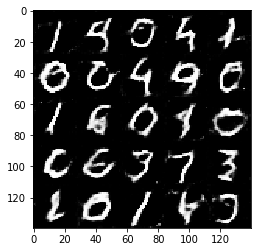

Epoch 2/4... Discriminator Loss: 1.4339... Generator Loss: 0.6958
Epoch 2/4... Discriminator Loss: 1.3726... Generator Loss: 0.7694
Epoch 2/4... Discriminator Loss: 1.3586... Generator Loss: 0.7311
Epoch 2/4... Discriminator Loss: 1.2433... Generator Loss: 0.8996
Epoch 2/4... Discriminator Loss: 1.4894... Generator Loss: 0.7641
Epoch 2/4... Discriminator Loss: 1.3465... Generator Loss: 0.8086
Epoch 2/4... Discriminator Loss: 1.3469... Generator Loss: 0.7499
Epoch 2/4... Discriminator Loss: 1.3111... Generator Loss: 1.0229
Epoch 2/4... Discriminator Loss: 1.3732... Generator Loss: 0.7942
Epoch 2/4... Discriminator Loss: 1.4048... Generator Loss: 0.6122
Epoch 2/4... Discriminator Loss: 1.3184... Generator Loss: 0.7132
Epoch 2/4... Discriminator Loss: 1.3018... Generator Loss: 0.9426
Epoch 2/4... Discriminator Loss: 1.3827... Generator Loss: 0.7986
Epoch 2/4... Discriminator Loss: 1.2737... Generator Loss: 0.8105
Epoch 2/4... Discriminator Loss: 1.4518... Generator Loss: 0.7752


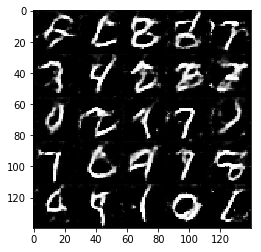

Epoch 2/4... Discriminator Loss: 1.2964... Generator Loss: 0.6997
Epoch 2/4... Discriminator Loss: 1.3987... Generator Loss: 0.8238
Epoch 2/4... Discriminator Loss: 1.3317... Generator Loss: 0.9477
Epoch 2/4... Discriminator Loss: 1.3253... Generator Loss: 0.9139
Epoch 2/4... Discriminator Loss: 1.3816... Generator Loss: 0.8522
Epoch 2/4... Discriminator Loss: 1.3034... Generator Loss: 0.7877
Epoch 2/4... Discriminator Loss: 1.3671... Generator Loss: 0.7490
Epoch 2/4... Discriminator Loss: 1.2932... Generator Loss: 0.7520
Epoch 2/4... Discriminator Loss: 1.4911... Generator Loss: 0.6348
Epoch 2/4... Discriminator Loss: 1.5504... Generator Loss: 1.1098
Epoch 2/4... Discriminator Loss: 1.4281... Generator Loss: 0.7741
Epoch 2/4... Discriminator Loss: 1.3042... Generator Loss: 0.9811
Epoch 2/4... Discriminator Loss: 1.4535... Generator Loss: 0.6990
Epoch 2/4... Discriminator Loss: 1.4481... Generator Loss: 0.6389
Epoch 2/4... Discriminator Loss: 1.4658... Generator Loss: 0.8886


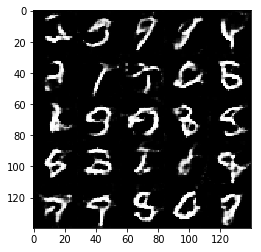

Epoch 2/4... Discriminator Loss: 1.4457... Generator Loss: 0.6831
Epoch 2/4... Discriminator Loss: 1.3685... Generator Loss: 0.5694
Epoch 2/4... Discriminator Loss: 1.2791... Generator Loss: 0.9165
Epoch 2/4... Discriminator Loss: 1.3495... Generator Loss: 0.9363
Epoch 2/4... Discriminator Loss: 1.3991... Generator Loss: 0.9331
Epoch 2/4... Discriminator Loss: 1.2591... Generator Loss: 0.7713
Epoch 2/4... Discriminator Loss: 1.4394... Generator Loss: 1.0436
Epoch 2/4... Discriminator Loss: 1.2112... Generator Loss: 1.0743
Epoch 2/4... Discriminator Loss: 1.3255... Generator Loss: 1.1462
Epoch 2/4... Discriminator Loss: 1.3136... Generator Loss: 0.7873
Epoch 2/4... Discriminator Loss: 1.2864... Generator Loss: 0.8578
Epoch 2/4... Discriminator Loss: 1.5046... Generator Loss: 0.7111
Epoch 2/4... Discriminator Loss: 1.3002... Generator Loss: 0.8443
Epoch 2/4... Discriminator Loss: 1.3571... Generator Loss: 0.6894
Epoch 2/4... Discriminator Loss: 1.3284... Generator Loss: 0.7235


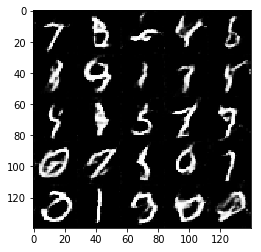

Epoch 2/4... Discriminator Loss: 1.5521... Generator Loss: 1.0032
Epoch 2/4... Discriminator Loss: 1.3445... Generator Loss: 0.7442
Epoch 2/4... Discriminator Loss: 1.3254... Generator Loss: 0.7554
Epoch 2/4... Discriminator Loss: 1.5652... Generator Loss: 0.9887
Epoch 2/4... Discriminator Loss: 1.3800... Generator Loss: 0.9066
Epoch 2/4... Discriminator Loss: 1.4202... Generator Loss: 0.6729
Epoch 2/4... Discriminator Loss: 1.2906... Generator Loss: 0.7939
Epoch 2/4... Discriminator Loss: 1.4262... Generator Loss: 0.8268
Epoch 2/4... Discriminator Loss: 1.5135... Generator Loss: 0.6974
Epoch 2/4... Discriminator Loss: 1.3754... Generator Loss: 0.7932
Epoch 2/4... Discriminator Loss: 1.5529... Generator Loss: 0.8008
Epoch 2/4... Discriminator Loss: 1.3899... Generator Loss: 0.7229
Epoch 2/4... Discriminator Loss: 1.3834... Generator Loss: 0.7075
Epoch 2/4... Discriminator Loss: 1.3635... Generator Loss: 0.8888
Epoch 2/4... Discriminator Loss: 1.4638... Generator Loss: 0.8051


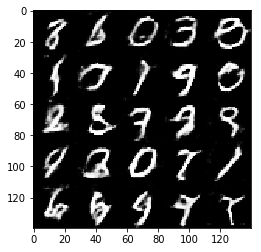

Epoch 2/4... Discriminator Loss: 1.3620... Generator Loss: 0.6965
Epoch 2/4... Discriminator Loss: 1.2442... Generator Loss: 0.9104
Epoch 2/4... Discriminator Loss: 1.4540... Generator Loss: 1.0757
Epoch 2/4... Discriminator Loss: 1.4501... Generator Loss: 0.7323
Epoch 2/4... Discriminator Loss: 1.3236... Generator Loss: 0.9405
Epoch 2/4... Discriminator Loss: 1.5425... Generator Loss: 0.5760
Epoch 2/4... Discriminator Loss: 1.3860... Generator Loss: 0.7989
Epoch 2/4... Discriminator Loss: 1.2929... Generator Loss: 0.7436
Epoch 2/4... Discriminator Loss: 1.3784... Generator Loss: 0.6847
Epoch 2/4... Discriminator Loss: 1.3006... Generator Loss: 0.7712
Epoch 2/4... Discriminator Loss: 1.2852... Generator Loss: 1.1475
Epoch 2/4... Discriminator Loss: 1.4923... Generator Loss: 0.7097
Epoch 2/4... Discriminator Loss: 1.4131... Generator Loss: 0.7566
Epoch 2/4... Discriminator Loss: 1.4474... Generator Loss: 0.9651
Epoch 2/4... Discriminator Loss: 1.4667... Generator Loss: 0.7369


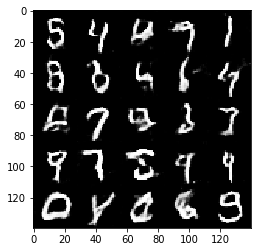

Epoch 2/4... Discriminator Loss: 1.3112... Generator Loss: 0.8247
Epoch 2/4... Discriminator Loss: 1.3937... Generator Loss: 0.7733
Epoch 2/4... Discriminator Loss: 1.4323... Generator Loss: 0.8562
Epoch 2/4... Discriminator Loss: 1.4937... Generator Loss: 0.8994
Epoch 2/4... Discriminator Loss: 1.4397... Generator Loss: 0.7668
Epoch 2/4... Discriminator Loss: 1.4075... Generator Loss: 0.7440
Epoch 2/4... Discriminator Loss: 1.5761... Generator Loss: 0.9768
Epoch 2/4... Discriminator Loss: 1.4608... Generator Loss: 1.1991
Epoch 2/4... Discriminator Loss: 1.4616... Generator Loss: 1.0031
Epoch 2/4... Discriminator Loss: 1.4107... Generator Loss: 0.9105
Epoch 2/4... Discriminator Loss: 1.3685... Generator Loss: 0.8929
Epoch 2/4... Discriminator Loss: 1.2979... Generator Loss: 0.7721
Epoch 2/4... Discriminator Loss: 1.3606... Generator Loss: 0.6765
Epoch 2/4... Discriminator Loss: 1.3425... Generator Loss: 0.9748
Epoch 2/4... Discriminator Loss: 1.4047... Generator Loss: 0.7438


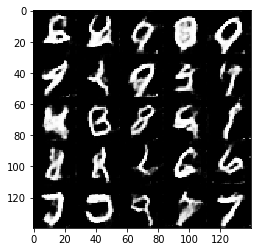

Epoch 2/4... Discriminator Loss: 1.4441... Generator Loss: 0.7933
Epoch 2/4... Discriminator Loss: 1.3708... Generator Loss: 0.6947
Epoch 2/4... Discriminator Loss: 1.3200... Generator Loss: 0.9395
Epoch 2/4... Discriminator Loss: 1.4747... Generator Loss: 0.9536
Epoch 2/4... Discriminator Loss: 1.3032... Generator Loss: 0.9929
Epoch 2/4... Discriminator Loss: 1.2813... Generator Loss: 0.9192
Epoch 2/4... Discriminator Loss: 1.3194... Generator Loss: 0.9930
Epoch 2/4... Discriminator Loss: 1.3600... Generator Loss: 1.0808
Epoch 2/4... Discriminator Loss: 1.3790... Generator Loss: 0.7574
Epoch 2/4... Discriminator Loss: 1.3792... Generator Loss: 0.7106
Epoch 2/4... Discriminator Loss: 1.3176... Generator Loss: 0.6835
Epoch 2/4... Discriminator Loss: 1.5540... Generator Loss: 0.9368
Epoch 2/4... Discriminator Loss: 1.2279... Generator Loss: 0.9286
Epoch 2/4... Discriminator Loss: 1.7559... Generator Loss: 0.6239
Epoch 2/4... Discriminator Loss: 1.4169... Generator Loss: 0.7080


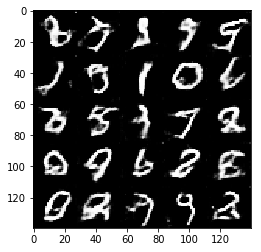

Epoch 2/4... Discriminator Loss: 1.2923... Generator Loss: 0.8226
Epoch 2/4... Discriminator Loss: 1.3534... Generator Loss: 0.8887
Epoch 2/4... Discriminator Loss: 1.3201... Generator Loss: 0.7973
Epoch 2/4... Discriminator Loss: 1.3680... Generator Loss: 0.8129
Epoch 2/4... Discriminator Loss: 1.3962... Generator Loss: 1.0755
Epoch 2/4... Discriminator Loss: 1.3783... Generator Loss: 0.7970
Epoch 2/4... Discriminator Loss: 1.3390... Generator Loss: 0.7964
Epoch 2/4... Discriminator Loss: 1.6210... Generator Loss: 0.7044
Epoch 2/4... Discriminator Loss: 1.3793... Generator Loss: 1.0747
Epoch 2/4... Discriminator Loss: 1.3436... Generator Loss: 0.9666
Epoch 2/4... Discriminator Loss: 1.2783... Generator Loss: 0.9320
Epoch 2/4... Discriminator Loss: 1.2853... Generator Loss: 0.8500
Epoch 2/4... Discriminator Loss: 1.4455... Generator Loss: 1.1177
Epoch 2/4... Discriminator Loss: 1.4051... Generator Loss: 0.7543
Epoch 2/4... Discriminator Loss: 1.3646... Generator Loss: 1.0544


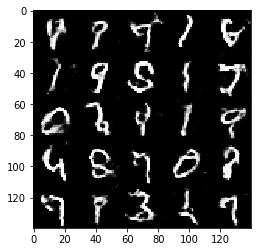

Epoch 3/4... Discriminator Loss: 1.4465... Generator Loss: 1.3655
Epoch 3/4... Discriminator Loss: 1.3247... Generator Loss: 0.6938
Epoch 3/4... Discriminator Loss: 1.3028... Generator Loss: 0.9426
Epoch 3/4... Discriminator Loss: 1.3195... Generator Loss: 0.8123
Epoch 3/4... Discriminator Loss: 1.3368... Generator Loss: 0.7872
Epoch 3/4... Discriminator Loss: 1.3724... Generator Loss: 0.8216
Epoch 3/4... Discriminator Loss: 1.4055... Generator Loss: 0.7012
Epoch 3/4... Discriminator Loss: 1.4301... Generator Loss: 0.7407
Epoch 3/4... Discriminator Loss: 1.3331... Generator Loss: 0.7611
Epoch 3/4... Discriminator Loss: 1.3174... Generator Loss: 0.8635
Epoch 3/4... Discriminator Loss: 1.5565... Generator Loss: 0.9981
Epoch 3/4... Discriminator Loss: 1.4825... Generator Loss: 0.7121
Epoch 3/4... Discriminator Loss: 1.3383... Generator Loss: 0.6952
Epoch 3/4... Discriminator Loss: 1.3956... Generator Loss: 1.1907
Epoch 3/4... Discriminator Loss: 1.3795... Generator Loss: 1.1886


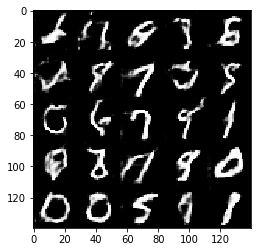

Epoch 3/4... Discriminator Loss: 1.3878... Generator Loss: 0.8260
Epoch 3/4... Discriminator Loss: 1.5386... Generator Loss: 0.7170
Epoch 3/4... Discriminator Loss: 1.4711... Generator Loss: 0.9192
Epoch 3/4... Discriminator Loss: 1.3174... Generator Loss: 0.7953
Epoch 3/4... Discriminator Loss: 1.4450... Generator Loss: 0.7881
Epoch 3/4... Discriminator Loss: 1.4151... Generator Loss: 0.7161
Epoch 3/4... Discriminator Loss: 1.4703... Generator Loss: 0.9550
Epoch 3/4... Discriminator Loss: 1.2942... Generator Loss: 1.0775
Epoch 3/4... Discriminator Loss: 1.4975... Generator Loss: 0.8885
Epoch 3/4... Discriminator Loss: 1.4322... Generator Loss: 0.7287
Epoch 3/4... Discriminator Loss: 1.5057... Generator Loss: 0.6861
Epoch 3/4... Discriminator Loss: 1.4416... Generator Loss: 0.8490
Epoch 3/4... Discriminator Loss: 1.4397... Generator Loss: 0.9637
Epoch 3/4... Discriminator Loss: 1.5223... Generator Loss: 0.7460
Epoch 3/4... Discriminator Loss: 1.4225... Generator Loss: 0.9925


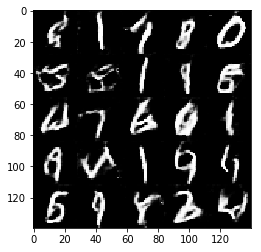

Epoch 3/4... Discriminator Loss: 1.4041... Generator Loss: 0.6907
Epoch 3/4... Discriminator Loss: 1.2872... Generator Loss: 0.8818
Epoch 3/4... Discriminator Loss: 1.3720... Generator Loss: 0.6450
Epoch 3/4... Discriminator Loss: 1.4316... Generator Loss: 0.6858
Epoch 3/4... Discriminator Loss: 1.2591... Generator Loss: 0.8537
Epoch 3/4... Discriminator Loss: 1.4661... Generator Loss: 0.7787
Epoch 3/4... Discriminator Loss: 1.3365... Generator Loss: 0.8740
Epoch 3/4... Discriminator Loss: 1.3405... Generator Loss: 0.8355
Epoch 3/4... Discriminator Loss: 1.3516... Generator Loss: 0.8727
Epoch 3/4... Discriminator Loss: 1.3798... Generator Loss: 0.7733
Epoch 3/4... Discriminator Loss: 1.4587... Generator Loss: 0.7652
Epoch 3/4... Discriminator Loss: 1.2089... Generator Loss: 1.2087
Epoch 3/4... Discriminator Loss: 1.5126... Generator Loss: 0.8329
Epoch 3/4... Discriminator Loss: 1.4245... Generator Loss: 0.7573
Epoch 3/4... Discriminator Loss: 1.3905... Generator Loss: 0.8527


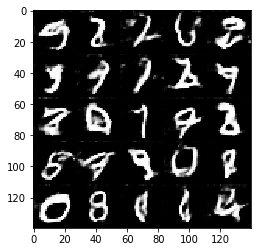

Epoch 3/4... Discriminator Loss: 1.3596... Generator Loss: 0.7902
Epoch 3/4... Discriminator Loss: 1.2188... Generator Loss: 0.7553
Epoch 3/4... Discriminator Loss: 1.4175... Generator Loss: 1.1793
Epoch 3/4... Discriminator Loss: 1.4068... Generator Loss: 0.7735
Epoch 3/4... Discriminator Loss: 1.3583... Generator Loss: 0.9390
Epoch 3/4... Discriminator Loss: 1.4242... Generator Loss: 0.7487
Epoch 3/4... Discriminator Loss: 1.5421... Generator Loss: 1.2935
Epoch 3/4... Discriminator Loss: 1.4175... Generator Loss: 0.8270
Epoch 3/4... Discriminator Loss: 1.5110... Generator Loss: 0.7502
Epoch 3/4... Discriminator Loss: 1.2973... Generator Loss: 0.8064
Epoch 3/4... Discriminator Loss: 1.4449... Generator Loss: 0.8383
Epoch 3/4... Discriminator Loss: 1.4001... Generator Loss: 0.8931
Epoch 3/4... Discriminator Loss: 1.3597... Generator Loss: 1.0990
Epoch 3/4... Discriminator Loss: 1.4631... Generator Loss: 0.7843
Epoch 3/4... Discriminator Loss: 1.2971... Generator Loss: 0.7294


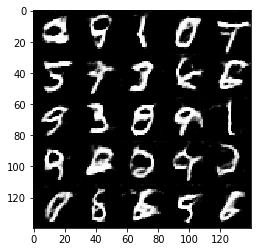

Epoch 3/4... Discriminator Loss: 1.3867... Generator Loss: 0.6587
Epoch 3/4... Discriminator Loss: 1.4066... Generator Loss: 1.0562
Epoch 3/4... Discriminator Loss: 1.3965... Generator Loss: 0.6919
Epoch 3/4... Discriminator Loss: 1.3653... Generator Loss: 0.8573
Epoch 3/4... Discriminator Loss: 1.3823... Generator Loss: 1.0511
Epoch 3/4... Discriminator Loss: 1.2802... Generator Loss: 0.7456
Epoch 3/4... Discriminator Loss: 1.4048... Generator Loss: 0.7206
Epoch 3/4... Discriminator Loss: 1.4947... Generator Loss: 0.6857
Epoch 3/4... Discriminator Loss: 1.3100... Generator Loss: 0.8155
Epoch 3/4... Discriminator Loss: 1.3027... Generator Loss: 0.8968
Epoch 3/4... Discriminator Loss: 1.3759... Generator Loss: 0.8540
Epoch 3/4... Discriminator Loss: 1.4075... Generator Loss: 0.7583
Epoch 3/4... Discriminator Loss: 1.4497... Generator Loss: 0.8307
Epoch 3/4... Discriminator Loss: 1.4228... Generator Loss: 0.8049
Epoch 3/4... Discriminator Loss: 1.3767... Generator Loss: 0.8713


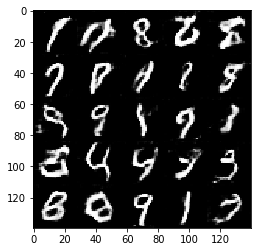

Epoch 3/4... Discriminator Loss: 1.3256... Generator Loss: 0.7844
Epoch 3/4... Discriminator Loss: 1.3974... Generator Loss: 0.8205
Epoch 3/4... Discriminator Loss: 1.2638... Generator Loss: 0.7375
Epoch 3/4... Discriminator Loss: 1.4332... Generator Loss: 0.7283
Epoch 3/4... Discriminator Loss: 1.4340... Generator Loss: 0.7331
Epoch 3/4... Discriminator Loss: 1.3821... Generator Loss: 0.9532
Epoch 3/4... Discriminator Loss: 1.3496... Generator Loss: 0.8992
Epoch 3/4... Discriminator Loss: 1.4133... Generator Loss: 0.9026
Epoch 3/4... Discriminator Loss: 1.4432... Generator Loss: 0.8256
Epoch 3/4... Discriminator Loss: 1.3798... Generator Loss: 0.6590
Epoch 3/4... Discriminator Loss: 1.4323... Generator Loss: 0.6914
Epoch 3/4... Discriminator Loss: 1.4696... Generator Loss: 0.6349
Epoch 3/4... Discriminator Loss: 1.4881... Generator Loss: 1.1953
Epoch 3/4... Discriminator Loss: 1.4403... Generator Loss: 1.1965
Epoch 3/4... Discriminator Loss: 1.3569... Generator Loss: 0.9648


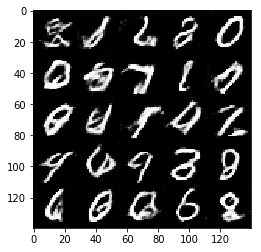

Epoch 3/4... Discriminator Loss: 1.3753... Generator Loss: 0.7370
Epoch 3/4... Discriminator Loss: 1.4413... Generator Loss: 1.0075
Epoch 3/4... Discriminator Loss: 1.3591... Generator Loss: 0.7003
Epoch 3/4... Discriminator Loss: 1.4768... Generator Loss: 0.8478
Epoch 3/4... Discriminator Loss: 1.3307... Generator Loss: 0.7861
Epoch 3/4... Discriminator Loss: 1.2973... Generator Loss: 1.2266
Epoch 3/4... Discriminator Loss: 1.3643... Generator Loss: 0.8522
Epoch 3/4... Discriminator Loss: 1.4314... Generator Loss: 0.8348
Epoch 3/4... Discriminator Loss: 1.4359... Generator Loss: 0.8127
Epoch 3/4... Discriminator Loss: 1.4399... Generator Loss: 0.7818
Epoch 3/4... Discriminator Loss: 1.5132... Generator Loss: 1.0168
Epoch 3/4... Discriminator Loss: 1.4399... Generator Loss: 0.7918
Epoch 3/4... Discriminator Loss: 1.3262... Generator Loss: 0.7905
Epoch 3/4... Discriminator Loss: 1.4314... Generator Loss: 0.8277
Epoch 3/4... Discriminator Loss: 1.4240... Generator Loss: 0.7901


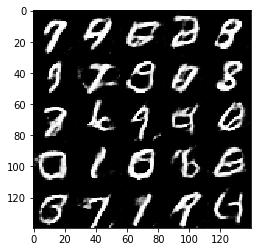

Epoch 3/4... Discriminator Loss: 1.4218... Generator Loss: 0.8260
Epoch 3/4... Discriminator Loss: 1.2803... Generator Loss: 0.7373
Epoch 3/4... Discriminator Loss: 1.4703... Generator Loss: 1.0959
Epoch 3/4... Discriminator Loss: 1.4039... Generator Loss: 0.8985
Epoch 3/4... Discriminator Loss: 1.4412... Generator Loss: 0.6806
Epoch 3/4... Discriminator Loss: 1.4414... Generator Loss: 0.6516
Epoch 3/4... Discriminator Loss: 1.5045... Generator Loss: 0.9451
Epoch 3/4... Discriminator Loss: 1.3171... Generator Loss: 0.8397
Epoch 3/4... Discriminator Loss: 1.4234... Generator Loss: 0.8027
Epoch 3/4... Discriminator Loss: 1.3517... Generator Loss: 0.8448
Epoch 3/4... Discriminator Loss: 1.2857... Generator Loss: 0.7548
Epoch 3/4... Discriminator Loss: 1.5459... Generator Loss: 0.8794
Epoch 3/4... Discriminator Loss: 1.3654... Generator Loss: 0.6705
Epoch 3/4... Discriminator Loss: 1.4021... Generator Loss: 0.7321
Epoch 3/4... Discriminator Loss: 1.3025... Generator Loss: 0.6422


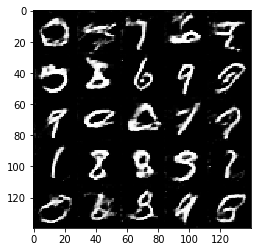

Epoch 3/4... Discriminator Loss: 1.3957... Generator Loss: 1.0504
Epoch 3/4... Discriminator Loss: 1.5046... Generator Loss: 1.1417
Epoch 3/4... Discriminator Loss: 1.4395... Generator Loss: 0.6347
Epoch 3/4... Discriminator Loss: 1.3019... Generator Loss: 0.7272
Epoch 3/4... Discriminator Loss: 1.3910... Generator Loss: 0.9784
Epoch 3/4... Discriminator Loss: 1.3599... Generator Loss: 0.8503
Epoch 3/4... Discriminator Loss: 1.3716... Generator Loss: 0.7332
Epoch 3/4... Discriminator Loss: 1.3322... Generator Loss: 0.9110
Epoch 3/4... Discriminator Loss: 1.4752... Generator Loss: 0.6837
Epoch 3/4... Discriminator Loss: 1.3547... Generator Loss: 0.8622
Epoch 3/4... Discriminator Loss: 1.3166... Generator Loss: 0.8298
Epoch 3/4... Discriminator Loss: 1.5282... Generator Loss: 0.8899
Epoch 3/4... Discriminator Loss: 1.3665... Generator Loss: 0.8284
Epoch 3/4... Discriminator Loss: 1.3331... Generator Loss: 0.6642
Epoch 3/4... Discriminator Loss: 1.2667... Generator Loss: 0.7704


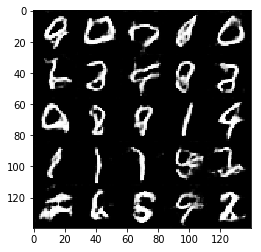

Epoch 3/4... Discriminator Loss: 1.4042... Generator Loss: 0.8840
Epoch 3/4... Discriminator Loss: 1.3721... Generator Loss: 0.7829
Epoch 3/4... Discriminator Loss: 1.3822... Generator Loss: 0.7344
Epoch 3/4... Discriminator Loss: 1.2778... Generator Loss: 0.7699
Epoch 3/4... Discriminator Loss: 1.4442... Generator Loss: 0.7320
Epoch 3/4... Discriminator Loss: 1.3035... Generator Loss: 0.9607
Epoch 3/4... Discriminator Loss: 1.4055... Generator Loss: 0.8491
Epoch 3/4... Discriminator Loss: 1.4484... Generator Loss: 0.7328
Epoch 3/4... Discriminator Loss: 1.4851... Generator Loss: 0.7206
Epoch 3/4... Discriminator Loss: 1.4066... Generator Loss: 0.7626
Epoch 3/4... Discriminator Loss: 1.4486... Generator Loss: 0.6079
Epoch 3/4... Discriminator Loss: 1.4455... Generator Loss: 0.7481
Epoch 3/4... Discriminator Loss: 1.3540... Generator Loss: 0.7595
Epoch 3/4... Discriminator Loss: 1.3936... Generator Loss: 0.7063
Epoch 3/4... Discriminator Loss: 1.4133... Generator Loss: 0.9979


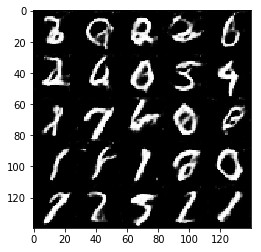

Epoch 3/4... Discriminator Loss: 1.4900... Generator Loss: 0.8048
Epoch 3/4... Discriminator Loss: 1.3840... Generator Loss: 0.8738
Epoch 3/4... Discriminator Loss: 1.3490... Generator Loss: 0.7102
Epoch 3/4... Discriminator Loss: 1.3339... Generator Loss: 1.0843
Epoch 3/4... Discriminator Loss: 1.4771... Generator Loss: 1.0883
Epoch 3/4... Discriminator Loss: 1.4229... Generator Loss: 0.8094
Epoch 3/4... Discriminator Loss: 1.3304... Generator Loss: 0.8992
Epoch 3/4... Discriminator Loss: 1.4626... Generator Loss: 0.6876
Epoch 3/4... Discriminator Loss: 1.3953... Generator Loss: 0.7003
Epoch 3/4... Discriminator Loss: 1.4489... Generator Loss: 0.9909
Epoch 3/4... Discriminator Loss: 1.4130... Generator Loss: 0.7970
Epoch 3/4... Discriminator Loss: 1.2519... Generator Loss: 0.9354
Epoch 3/4... Discriminator Loss: 1.2614... Generator Loss: 0.8414
Epoch 3/4... Discriminator Loss: 1.3692... Generator Loss: 1.1829
Epoch 3/4... Discriminator Loss: 1.2472... Generator Loss: 0.8919


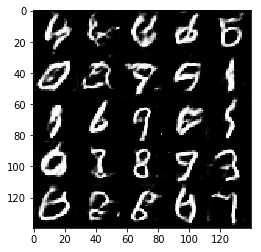

Epoch 3/4... Discriminator Loss: 1.3427... Generator Loss: 0.8519
Epoch 3/4... Discriminator Loss: 1.3926... Generator Loss: 0.8178
Epoch 3/4... Discriminator Loss: 1.3908... Generator Loss: 0.7735
Epoch 3/4... Discriminator Loss: 1.3620... Generator Loss: 0.9734
Epoch 3/4... Discriminator Loss: 1.4606... Generator Loss: 0.7544
Epoch 3/4... Discriminator Loss: 1.4426... Generator Loss: 0.6555
Epoch 3/4... Discriminator Loss: 1.6131... Generator Loss: 0.6614
Epoch 3/4... Discriminator Loss: 1.6509... Generator Loss: 0.8504
Epoch 3/4... Discriminator Loss: 1.5541... Generator Loss: 0.7349
Epoch 3/4... Discriminator Loss: 1.2891... Generator Loss: 0.8444
Epoch 3/4... Discriminator Loss: 1.3229... Generator Loss: 0.8587
Epoch 3/4... Discriminator Loss: 1.4063... Generator Loss: 0.9050
Epoch 3/4... Discriminator Loss: 1.4922... Generator Loss: 1.0694
Epoch 3/4... Discriminator Loss: 1.3001... Generator Loss: 0.8014
Epoch 3/4... Discriminator Loss: 1.4053... Generator Loss: 0.6805


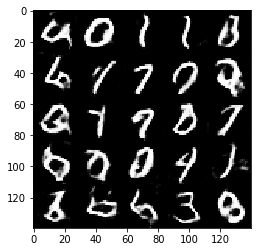

Epoch 3/4... Discriminator Loss: 1.2593... Generator Loss: 0.7556
Epoch 3/4... Discriminator Loss: 1.4225... Generator Loss: 0.7793
Epoch 3/4... Discriminator Loss: 1.4429... Generator Loss: 0.7405
Epoch 3/4... Discriminator Loss: 1.3300... Generator Loss: 0.8455
Epoch 3/4... Discriminator Loss: 1.2915... Generator Loss: 0.6898
Epoch 3/4... Discriminator Loss: 1.4041... Generator Loss: 0.8721
Epoch 3/4... Discriminator Loss: 1.3429... Generator Loss: 0.7228
Epoch 4/4... Discriminator Loss: 1.2625... Generator Loss: 0.8737
Epoch 4/4... Discriminator Loss: 1.3065... Generator Loss: 0.8188
Epoch 4/4... Discriminator Loss: 1.3977... Generator Loss: 0.8250
Epoch 4/4... Discriminator Loss: 1.3320... Generator Loss: 0.9622
Epoch 4/4... Discriminator Loss: 1.3541... Generator Loss: 0.9196
Epoch 4/4... Discriminator Loss: 1.3885... Generator Loss: 0.9251
Epoch 4/4... Discriminator Loss: 1.4360... Generator Loss: 0.7418
Epoch 4/4... Discriminator Loss: 1.3495... Generator Loss: 0.9184


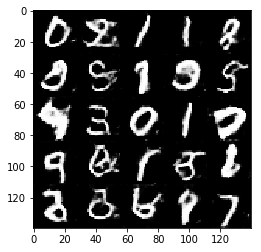

Epoch 4/4... Discriminator Loss: 1.3592... Generator Loss: 0.7677
Epoch 4/4... Discriminator Loss: 1.3876... Generator Loss: 0.8778
Epoch 4/4... Discriminator Loss: 1.4445... Generator Loss: 0.7923
Epoch 4/4... Discriminator Loss: 1.2634... Generator Loss: 0.9577
Epoch 4/4... Discriminator Loss: 1.3839... Generator Loss: 0.7566
Epoch 4/4... Discriminator Loss: 1.4146... Generator Loss: 0.6902
Epoch 4/4... Discriminator Loss: 1.3841... Generator Loss: 0.9256
Epoch 4/4... Discriminator Loss: 1.4091... Generator Loss: 0.7040
Epoch 4/4... Discriminator Loss: 1.2049... Generator Loss: 0.8017
Epoch 4/4... Discriminator Loss: 1.3821... Generator Loss: 0.7211
Epoch 4/4... Discriminator Loss: 1.2278... Generator Loss: 0.8239
Epoch 4/4... Discriminator Loss: 1.3947... Generator Loss: 1.1037
Epoch 4/4... Discriminator Loss: 1.3352... Generator Loss: 0.8870
Epoch 4/4... Discriminator Loss: 1.4350... Generator Loss: 0.7580
Epoch 4/4... Discriminator Loss: 1.4700... Generator Loss: 0.7766


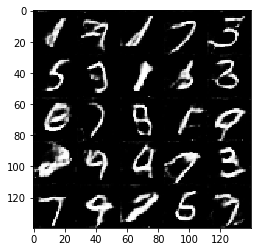

Epoch 4/4... Discriminator Loss: 1.2917... Generator Loss: 0.8067
Epoch 4/4... Discriminator Loss: 1.3877... Generator Loss: 0.8861
Epoch 4/4... Discriminator Loss: 1.2083... Generator Loss: 0.6688
Epoch 4/4... Discriminator Loss: 1.4236... Generator Loss: 1.0728
Epoch 4/4... Discriminator Loss: 1.2819... Generator Loss: 0.6986
Epoch 4/4... Discriminator Loss: 1.4431... Generator Loss: 0.7521
Epoch 4/4... Discriminator Loss: 1.3218... Generator Loss: 0.8183
Epoch 4/4... Discriminator Loss: 1.3542... Generator Loss: 0.9051
Epoch 4/4... Discriminator Loss: 1.3350... Generator Loss: 0.7582
Epoch 4/4... Discriminator Loss: 1.4064... Generator Loss: 0.8553
Epoch 4/4... Discriminator Loss: 1.3211... Generator Loss: 0.8607
Epoch 4/4... Discriminator Loss: 1.2473... Generator Loss: 0.8111
Epoch 4/4... Discriminator Loss: 1.5658... Generator Loss: 0.6460
Epoch 4/4... Discriminator Loss: 1.3817... Generator Loss: 0.9664
Epoch 4/4... Discriminator Loss: 1.4393... Generator Loss: 0.7220


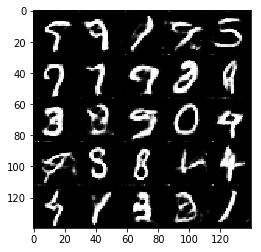

Epoch 4/4... Discriminator Loss: 1.4606... Generator Loss: 0.8199
Epoch 4/4... Discriminator Loss: 1.4317... Generator Loss: 0.8319
Epoch 4/4... Discriminator Loss: 1.3627... Generator Loss: 0.8007
Epoch 4/4... Discriminator Loss: 1.4413... Generator Loss: 1.1266
Epoch 4/4... Discriminator Loss: 1.2323... Generator Loss: 0.9868
Epoch 4/4... Discriminator Loss: 1.4372... Generator Loss: 0.6464
Epoch 4/4... Discriminator Loss: 1.4020... Generator Loss: 0.7658
Epoch 4/4... Discriminator Loss: 1.3466... Generator Loss: 0.8963
Epoch 4/4... Discriminator Loss: 1.3322... Generator Loss: 0.8577
Epoch 4/4... Discriminator Loss: 1.2559... Generator Loss: 0.7385
Epoch 4/4... Discriminator Loss: 1.3931... Generator Loss: 1.0332
Epoch 4/4... Discriminator Loss: 1.3800... Generator Loss: 0.7279
Epoch 4/4... Discriminator Loss: 1.3092... Generator Loss: 0.8885
Epoch 4/4... Discriminator Loss: 1.3995... Generator Loss: 1.0251
Epoch 4/4... Discriminator Loss: 1.3952... Generator Loss: 0.9589


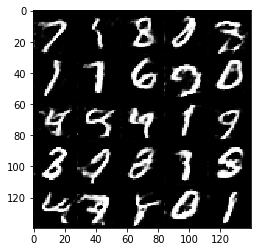

Epoch 4/4... Discriminator Loss: 1.5019... Generator Loss: 1.3201
Epoch 4/4... Discriminator Loss: 1.3191... Generator Loss: 0.7580
Epoch 4/4... Discriminator Loss: 1.3281... Generator Loss: 0.8124
Epoch 4/4... Discriminator Loss: 1.3006... Generator Loss: 0.6929
Epoch 4/4... Discriminator Loss: 1.4405... Generator Loss: 0.6072
Epoch 4/4... Discriminator Loss: 1.3904... Generator Loss: 0.7041
Epoch 4/4... Discriminator Loss: 1.4998... Generator Loss: 0.7756
Epoch 4/4... Discriminator Loss: 1.3407... Generator Loss: 0.7377
Epoch 4/4... Discriminator Loss: 1.2983... Generator Loss: 0.8393
Epoch 4/4... Discriminator Loss: 1.4132... Generator Loss: 0.7553
Epoch 4/4... Discriminator Loss: 1.4805... Generator Loss: 0.6601
Epoch 4/4... Discriminator Loss: 1.4033... Generator Loss: 0.6739
Epoch 4/4... Discriminator Loss: 1.4528... Generator Loss: 1.0432
Epoch 4/4... Discriminator Loss: 1.4102... Generator Loss: 0.6522
Epoch 4/4... Discriminator Loss: 1.3612... Generator Loss: 0.7454


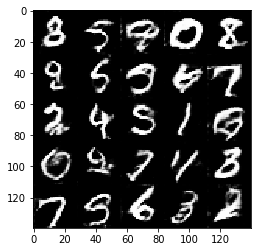

Epoch 4/4... Discriminator Loss: 1.3922... Generator Loss: 0.7402
Epoch 4/4... Discriminator Loss: 1.2723... Generator Loss: 1.0564
Epoch 4/4... Discriminator Loss: 1.4623... Generator Loss: 0.7332
Epoch 4/4... Discriminator Loss: 1.4510... Generator Loss: 0.6702
Epoch 4/4... Discriminator Loss: 1.3540... Generator Loss: 0.8780
Epoch 4/4... Discriminator Loss: 1.4722... Generator Loss: 0.9289
Epoch 4/4... Discriminator Loss: 1.2969... Generator Loss: 0.8811
Epoch 4/4... Discriminator Loss: 1.2715... Generator Loss: 0.9045
Epoch 4/4... Discriminator Loss: 1.4210... Generator Loss: 0.8762
Epoch 4/4... Discriminator Loss: 1.4282... Generator Loss: 0.7362
Epoch 4/4... Discriminator Loss: 1.4145... Generator Loss: 0.8131
Epoch 4/4... Discriminator Loss: 1.3172... Generator Loss: 0.9530
Epoch 4/4... Discriminator Loss: 1.3292... Generator Loss: 0.9242
Epoch 4/4... Discriminator Loss: 1.3587... Generator Loss: 0.9163
Epoch 4/4... Discriminator Loss: 1.3089... Generator Loss: 0.8322


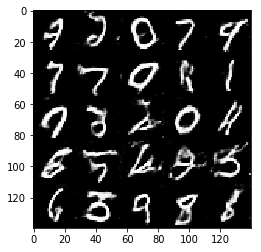

Epoch 4/4... Discriminator Loss: 1.3124... Generator Loss: 0.9135
Epoch 4/4... Discriminator Loss: 1.4628... Generator Loss: 0.7079
Epoch 4/4... Discriminator Loss: 1.4642... Generator Loss: 0.7303
Epoch 4/4... Discriminator Loss: 1.3382... Generator Loss: 0.6886
Epoch 4/4... Discriminator Loss: 1.4101... Generator Loss: 1.0765
Epoch 4/4... Discriminator Loss: 1.3253... Generator Loss: 0.8346
Epoch 4/4... Discriminator Loss: 1.3728... Generator Loss: 0.9259
Epoch 4/4... Discriminator Loss: 1.3228... Generator Loss: 0.6771
Epoch 4/4... Discriminator Loss: 1.2773... Generator Loss: 0.8567
Epoch 4/4... Discriminator Loss: 1.3768... Generator Loss: 0.7124
Epoch 4/4... Discriminator Loss: 1.3293... Generator Loss: 0.9386
Epoch 4/4... Discriminator Loss: 1.3559... Generator Loss: 0.7545
Epoch 4/4... Discriminator Loss: 1.4009... Generator Loss: 0.8299
Epoch 4/4... Discriminator Loss: 1.4390... Generator Loss: 0.7258
Epoch 4/4... Discriminator Loss: 1.3433... Generator Loss: 0.6955


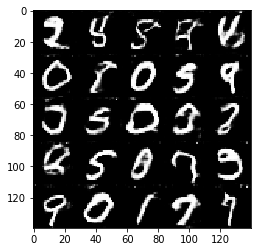

Epoch 4/4... Discriminator Loss: 1.4478... Generator Loss: 0.6863
Epoch 4/4... Discriminator Loss: 1.4885... Generator Loss: 0.6855
Epoch 4/4... Discriminator Loss: 1.3902... Generator Loss: 0.9160
Epoch 4/4... Discriminator Loss: 1.3643... Generator Loss: 0.9656
Epoch 4/4... Discriminator Loss: 1.3133... Generator Loss: 0.7401
Epoch 4/4... Discriminator Loss: 1.3811... Generator Loss: 0.7645
Epoch 4/4... Discriminator Loss: 1.4226... Generator Loss: 0.8631
Epoch 4/4... Discriminator Loss: 1.2663... Generator Loss: 0.7169
Epoch 4/4... Discriminator Loss: 1.4371... Generator Loss: 0.7197
Epoch 4/4... Discriminator Loss: 1.4359... Generator Loss: 0.6776
Epoch 4/4... Discriminator Loss: 1.2751... Generator Loss: 0.9002
Epoch 4/4... Discriminator Loss: 1.2888... Generator Loss: 0.7013
Epoch 4/4... Discriminator Loss: 1.3113... Generator Loss: 0.7007
Epoch 4/4... Discriminator Loss: 1.5163... Generator Loss: 0.6574
Epoch 4/4... Discriminator Loss: 1.5289... Generator Loss: 0.8288


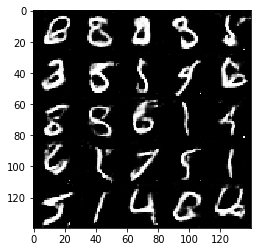

Epoch 4/4... Discriminator Loss: 1.3841... Generator Loss: 0.7027
Epoch 4/4... Discriminator Loss: 1.4567... Generator Loss: 0.9420
Epoch 4/4... Discriminator Loss: 1.2856... Generator Loss: 0.7617
Epoch 4/4... Discriminator Loss: 1.4201... Generator Loss: 0.7194
Epoch 4/4... Discriminator Loss: 1.3766... Generator Loss: 0.8478
Epoch 4/4... Discriminator Loss: 1.2709... Generator Loss: 0.7489
Epoch 4/4... Discriminator Loss: 1.4225... Generator Loss: 1.0002
Epoch 4/4... Discriminator Loss: 1.3000... Generator Loss: 0.9564
Epoch 4/4... Discriminator Loss: 1.3731... Generator Loss: 0.7631
Epoch 4/4... Discriminator Loss: 1.3985... Generator Loss: 0.7630
Epoch 4/4... Discriminator Loss: 1.3708... Generator Loss: 0.8140
Epoch 4/4... Discriminator Loss: 1.3895... Generator Loss: 0.6904
Epoch 4/4... Discriminator Loss: 1.3490... Generator Loss: 0.7679
Epoch 4/4... Discriminator Loss: 1.3019... Generator Loss: 0.7573
Epoch 4/4... Discriminator Loss: 1.3639... Generator Loss: 0.7990


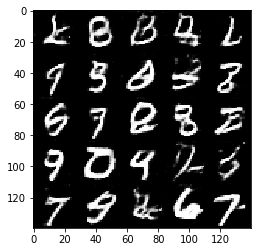

Epoch 4/4... Discriminator Loss: 1.4252... Generator Loss: 0.8127
Epoch 4/4... Discriminator Loss: 1.3632... Generator Loss: 0.8566
Epoch 4/4... Discriminator Loss: 1.4446... Generator Loss: 1.0434
Epoch 4/4... Discriminator Loss: 1.5088... Generator Loss: 0.7708
Epoch 4/4... Discriminator Loss: 1.4022... Generator Loss: 0.7493
Epoch 4/4... Discriminator Loss: 1.3954... Generator Loss: 0.7262
Epoch 4/4... Discriminator Loss: 1.4503... Generator Loss: 0.7915
Epoch 4/4... Discriminator Loss: 1.4676... Generator Loss: 0.8594
Epoch 4/4... Discriminator Loss: 1.3478... Generator Loss: 0.5771
Epoch 4/4... Discriminator Loss: 1.3079... Generator Loss: 0.8827
Epoch 4/4... Discriminator Loss: 1.3613... Generator Loss: 0.6620
Epoch 4/4... Discriminator Loss: 1.4082... Generator Loss: 0.7972
Epoch 4/4... Discriminator Loss: 1.4162... Generator Loss: 0.7266
Epoch 4/4... Discriminator Loss: 1.3655... Generator Loss: 0.7759
Epoch 4/4... Discriminator Loss: 1.3243... Generator Loss: 1.0621


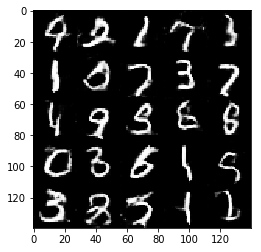

Epoch 4/4... Discriminator Loss: 1.3742... Generator Loss: 0.7410
Epoch 4/4... Discriminator Loss: 1.3920... Generator Loss: 0.7089
Epoch 4/4... Discriminator Loss: 1.4284... Generator Loss: 1.1071
Epoch 4/4... Discriminator Loss: 1.2699... Generator Loss: 0.8858
Epoch 4/4... Discriminator Loss: 1.4142... Generator Loss: 0.8679
Epoch 4/4... Discriminator Loss: 1.3538... Generator Loss: 0.9123
Epoch 4/4... Discriminator Loss: 1.4897... Generator Loss: 0.7287
Epoch 4/4... Discriminator Loss: 1.3300... Generator Loss: 0.6617
Epoch 4/4... Discriminator Loss: 1.3053... Generator Loss: 0.8637
Epoch 4/4... Discriminator Loss: 1.5037... Generator Loss: 1.1060
Epoch 4/4... Discriminator Loss: 1.3725... Generator Loss: 0.8361
Epoch 4/4... Discriminator Loss: 1.3758... Generator Loss: 0.6879
Epoch 4/4... Discriminator Loss: 1.4066... Generator Loss: 1.0314
Epoch 4/4... Discriminator Loss: 1.3690... Generator Loss: 0.8649
Epoch 4/4... Discriminator Loss: 1.2111... Generator Loss: 0.7921


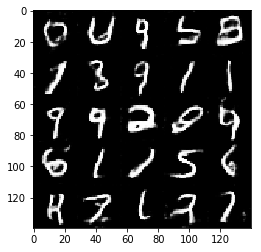

Epoch 4/4... Discriminator Loss: 1.3911... Generator Loss: 0.8480
Epoch 4/4... Discriminator Loss: 1.3481... Generator Loss: 0.7287
Epoch 4/4... Discriminator Loss: 1.4181... Generator Loss: 1.0639
Epoch 4/4... Discriminator Loss: 1.2795... Generator Loss: 0.7404
Epoch 4/4... Discriminator Loss: 1.3505... Generator Loss: 0.9687
Epoch 4/4... Discriminator Loss: 1.6690... Generator Loss: 0.5452
Epoch 4/4... Discriminator Loss: 1.2374... Generator Loss: 0.8233
Epoch 4/4... Discriminator Loss: 1.3948... Generator Loss: 0.6441
Epoch 4/4... Discriminator Loss: 1.4381... Generator Loss: 0.6273
Epoch 4/4... Discriminator Loss: 1.3609... Generator Loss: 0.7318
Epoch 4/4... Discriminator Loss: 1.3961... Generator Loss: 0.7484
Epoch 4/4... Discriminator Loss: 1.3644... Generator Loss: 0.6394
Epoch 4/4... Discriminator Loss: 1.3168... Generator Loss: 0.7593
Epoch 4/4... Discriminator Loss: 1.4127... Generator Loss: 0.7027
Epoch 4/4... Discriminator Loss: 1.4086... Generator Loss: 0.8449


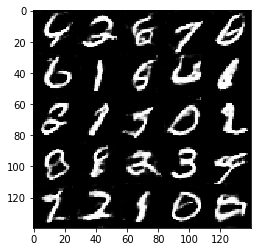

Epoch 4/4... Discriminator Loss: 1.2386... Generator Loss: 0.9944
Epoch 4/4... Discriminator Loss: 1.3266... Generator Loss: 0.6814
Epoch 4/4... Discriminator Loss: 1.3235... Generator Loss: 0.7622
Epoch 4/4... Discriminator Loss: 1.3300... Generator Loss: 0.7083
Epoch 4/4... Discriminator Loss: 1.2572... Generator Loss: 0.9205
Epoch 4/4... Discriminator Loss: 1.2976... Generator Loss: 0.8349
Epoch 4/4... Discriminator Loss: 1.4038... Generator Loss: 0.7608
Epoch 4/4... Discriminator Loss: 1.3105... Generator Loss: 0.7563
Epoch 4/4... Discriminator Loss: 1.2691... Generator Loss: 0.9261
Epoch 4/4... Discriminator Loss: 1.4252... Generator Loss: 0.7315
Epoch 4/4... Discriminator Loss: 1.3722... Generator Loss: 0.8324
Epoch 4/4... Discriminator Loss: 1.4425... Generator Loss: 0.8626
Epoch 4/4... Discriminator Loss: 1.4285... Generator Loss: 0.7886
Epoch 4/4... Discriminator Loss: 1.3101... Generator Loss: 0.7685
Epoch 4/4... Discriminator Loss: 1.2773... Generator Loss: 0.8616


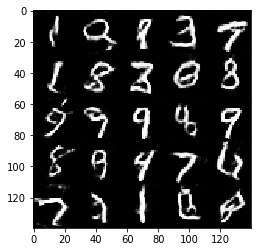

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 3.0745
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 2.5157
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 2.6511
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 2.4403
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 2.6887
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 2.2651
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 2.9028
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 2.1479
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 2.1302
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 2.1704
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 2.1411
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 3.1009
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.8324
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 1.5763


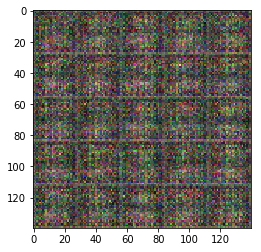

Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 2.8995
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 2.1692
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 5.3108
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 3.4689
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 2.9090
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 2.0411
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 2.3611
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 3.3989
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.9497
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 2.7332
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 2.9079
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 2.4487
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 2.0988
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.5856
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 2.7032


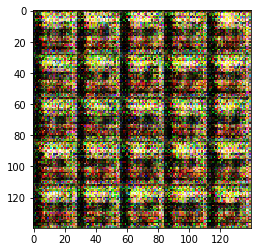

Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 3.2891
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 3.8181
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 2.4730
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 4.0744
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 2.7708
Epoch 1/1... Discriminator Loss: 1.6492... Generator Loss: 2.7849
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 1.9562
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 2.1349
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 2.4890
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 2.1508
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 2.6808
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 2.7150
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 3.2590
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 3.4444
Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 3.3236


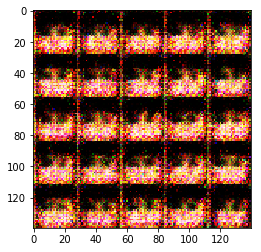

Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 2.0976
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 1.5351
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 2.5543
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 2.7269
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 4.3634
Epoch 1/1... Discriminator Loss: 0.9955... Generator Loss: 2.8000
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 4.1448
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 2.8748
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 3.2967
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.9341
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 2.2147
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 2.7897
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.7077
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 2.1476
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 2.9254


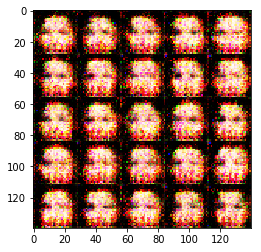

Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 3.3459
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 3.8057
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 2.0308
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 2.3502
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 3.5270
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 2.4986
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 4.1925
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 3.0701
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 5.0648
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 3.8750
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 2.5416
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 2.5158
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 3.0684
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 2.0532


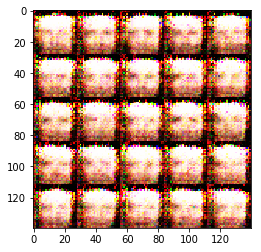

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 2.8843
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 3.0946
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 2.1588
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 3.3393
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 3.0846
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 2.3650
Epoch 1/1... Discriminator Loss: 0.9335... Generator Loss: 2.3658
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 2.9919
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 3.0465
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 2.0516
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 3.0460
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 2.7124
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 2.5313
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 2.0792
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 3.0536


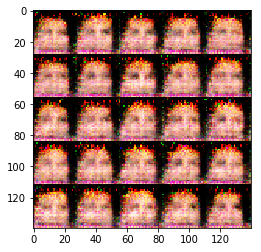

Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 3.6115
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 1.8794
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 2.5465
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 3.3741
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 3.2293
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 3.2494
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 3.3307
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 3.0967
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 2.3436
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 2.2799
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 2.5474
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 3.2955
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 3.1930
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 4.2279


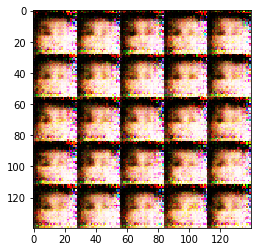

Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 2.5607
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 2.3921
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 3.6618
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 2.5290
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 3.2370
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 2.6648
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 2.3259
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 2.5857
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 2.2538
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 2.8668
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 3.4792
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 3.2031
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 2.5356
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 2.8999
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 3.1494


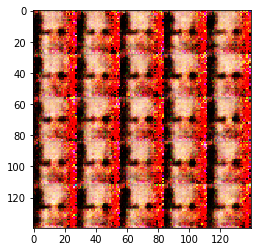

Epoch 1/1... Discriminator Loss: 1.1286... Generator Loss: 2.3266
Epoch 1/1... Discriminator Loss: 1.0656... Generator Loss: 2.5353
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 3.4686
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 3.2245
Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.7978
Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 3.3580
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 3.2461
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 3.1704
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 2.8156
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 3.1594
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 3.2084
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 2.8869
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 2.1633
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 3.2875
Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 3.6746


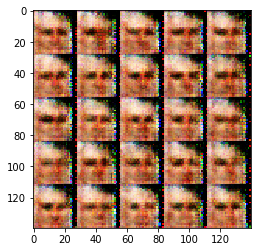

Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 2.7314
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 3.1838
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 2.6787
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 2.4777
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 2.6874
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 2.4676
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 2.3298
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 2.9765
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 4.0483
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 2.1357
Epoch 1/1... Discriminator Loss: 1.0224... Generator Loss: 3.2403
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 2.1537
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 2.1309


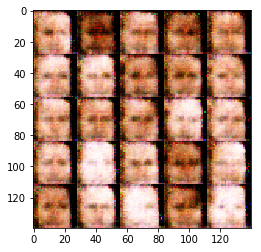

Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 3.9997
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 3.0999
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 2.2841
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 2.4107
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 1.8615
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 3.1985
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 2.9677
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 2.3399
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.6268
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.6468
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 2.0830
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 2.2550
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 2.7234
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 2.4629
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 3.5255


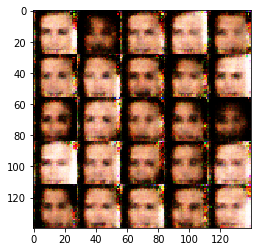

Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.7680
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 2.9825
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 2.9316
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 2.9892
Epoch 1/1... Discriminator Loss: 0.9933... Generator Loss: 2.5113
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 2.3141
Epoch 1/1... Discriminator Loss: 1.1457... Generator Loss: 3.0395
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.7377
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 2.8310
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 2.8378
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 2.0904
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 3.2201
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 2.1954
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 2.8928
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 2.2710


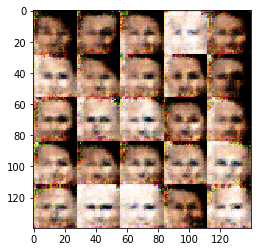

Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 3.4125
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 2.4310
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 2.8286
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.5943
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.7873
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 2.1487
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 2.7194
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.9872
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 1.5136
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 1.5529
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 3.6700
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 1.3231


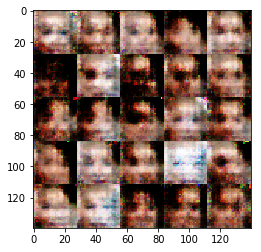

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.6804
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 2.3458
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 2.0463
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 1.9884
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 1.5979
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 3.2845
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 2.5732
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 2.3039
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.8487


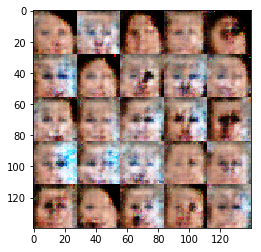

Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 2.0571
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 1.9750
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 1.7140
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 1.5397
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 1.4245
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 1.4520
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.9449
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 1.8044
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.6058
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 2.1169
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 2.2661
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8171


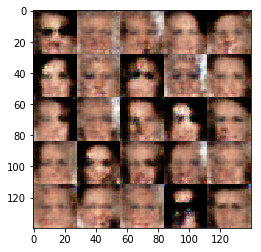

Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.5938
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 1.6704
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.8507
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 1.9118
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 2.7068
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 2.3978
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 2.0693
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 2.5194
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.4526
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 1.3677
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.5259
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 2.0603
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 2.2016


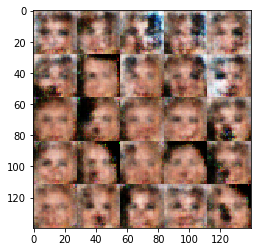

Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 2.0076
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 2.0012
Epoch 1/1... Discriminator Loss: 1.1542... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 1.5714
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 1.5295... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 2.2880
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.7341
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 1.6611


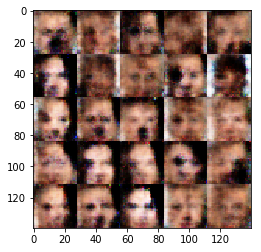

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 2.5773
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 1.8090
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 2.3824
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 2.2469
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 1.5261
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 1.3312
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.4888
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.7119
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.7228
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 2.1557


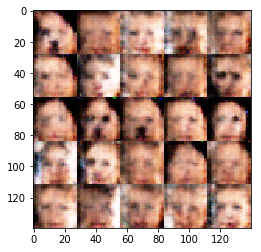

Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.8820
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 1.1771
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 1.2765
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 1.8682
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 1.1666
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.7593
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.2820


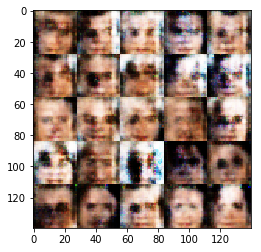

Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 1.5503
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 1.3345
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 1.6068
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 1.5434
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 2.9166
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.2705
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 1.1859
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 1.6481
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 1.2649


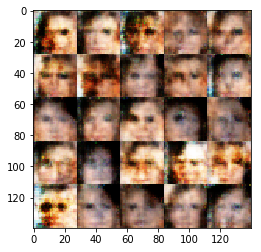

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 1.8015
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.3833
Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.1603
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.2560
Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 1.2778
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 1.4898
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.1447


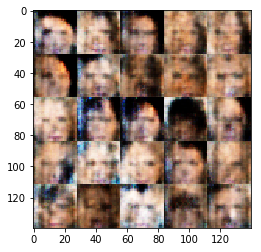

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 1.3555
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 1.0849
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.1608... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 1.2382
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 2.2297
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 1.2757


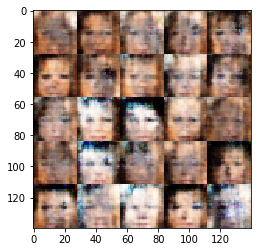

Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.6879... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 1.5211
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.5076
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 1.8684
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 1.7121
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 1.2109
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.3288
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.6426
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 1.5789


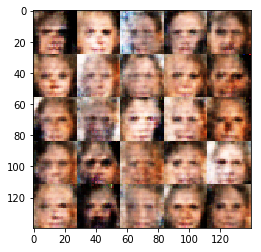

Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 1.0860
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.3688
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 1.2081
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 1.4010
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 2.1017
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.5451... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 1.1613
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 1.0994


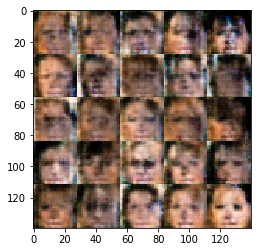

Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 1.3698
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9809
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 1.5965
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 1.5602
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 1.3865
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 1.1993


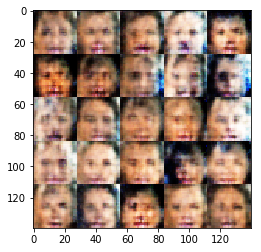

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.4238
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 1.4768
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 1.1698
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.1387
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 1.5729
Epoch 1/1... Discriminator Loss: 1.2372... Generator Loss: 1.2481


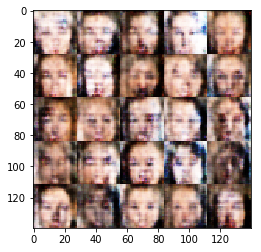

Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.3668
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 1.5493
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 1.3898
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 1.2506


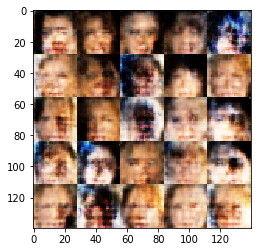

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 1.3111
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 1.2821
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 1.3182
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 1.1163


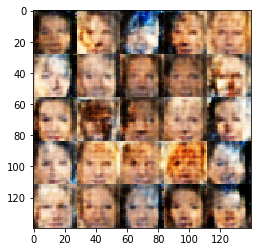

Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 1.0444
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.1462
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.4367
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 1.0998


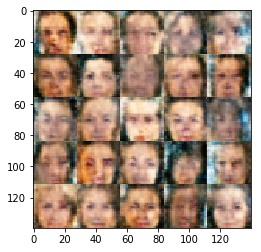

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.5016
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.4985... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.2078
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.1458
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 1.1530
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 1.3008
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 1.4246


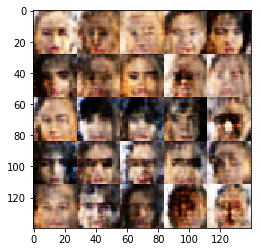

Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 1.2041
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 1.4541
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.3963
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 1.0400


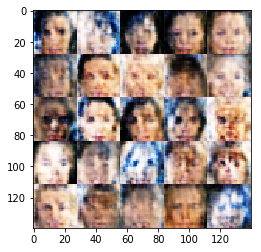

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.9933
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 1.1920
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 1.1035
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 1.0191


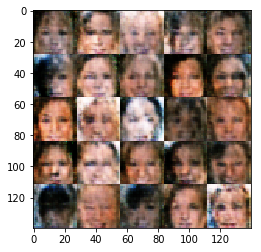

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 1.1338
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 1.2409
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.9050


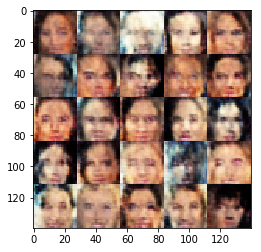

Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 1.1135
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 1.0350
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 1.1801


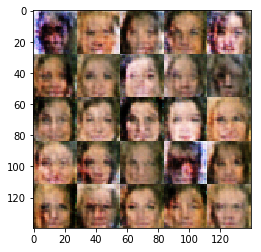

Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 1.0979
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 1.2823
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 1.0284
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 1.0228
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.1237


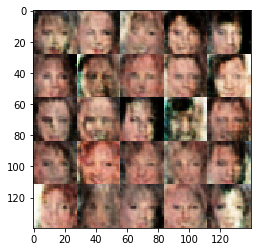

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.1433
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 1.3877


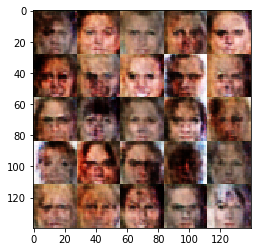

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9422
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 1.2122
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8837


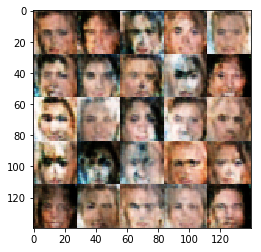

Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 1.1040
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.9576
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.8253


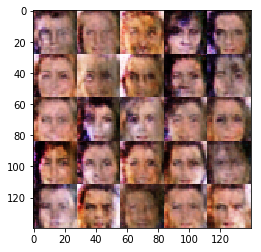

Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8626


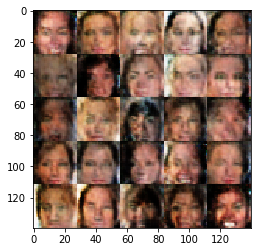

Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8884


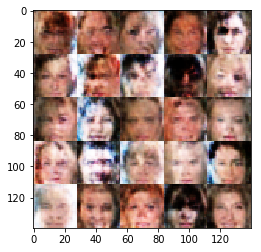

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.3272
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9370


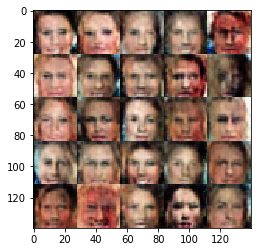

Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.2576
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.1589
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 1.1648
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7534


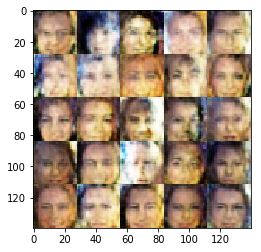

Epoch 1/1... Discriminator Loss: 1.6337... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6236


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.